In [2]:
using Revise
using SSMCMain, SSMCMain.MinimalModelSemisymbolic

using Base.Threads

using Symbolics
import Nemo

using JLD2
using DataFrames, FreqTables, AlgebraOfGraphics, NamedArrays, StatsBase


Welcome to Nemo version 0.48.4

Nemo comes with absolutely no warranty whatsoever


In [81]:
using GLMakie
using CairoMakie
CairoMakie.activate!()
# GLMakie.activate!(; px_per_unit=1.)
# display(GLMakie.Screen(), f.figure)
ENV["COLUMNS"] = 280

280

# Loading pscan data

In [41]:
data = jldopen("../cluster_env/runs/mmsa_pscan4/out.jld2");
params_mlKcd = [data[x] for x in ["m", "l", "K", "c", "d"]];
params_Ds = [data[x] for x in ["DN", "DG", "DR"]];
df = data["df"];

In [59]:
function get_random_row(df)
    df[rand(1:nrow(df)),:]
end
function df_correlations(df)
    NamedArray(cor(Matrix(df)), (names(df), names(df)))
end
function df_row_to_mmp(dfrow)
    MinimalModelParamsSpace(
        dfrow.m, dfrow.l, dfrow.K, dfrow.c, dfrow.d,
        dfrow.DN, dfrow.DG, dfrow.DR
    )
end

df_row_to_mmp (generic function with 1 method)

# Basics

In [61]:
get_random_row(df)

Row,m,l,K,c,d,DN,DG,DR,numss,nummodes
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64
25909208,0.13313,1.0,32.0,0.5,0.015625,0.000615848,23357.2,3.79269,1,1


In [44]:
@show nrow(df)
describe(df)

nrow(df) = 35549363


Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,m,0.600095,0.0078125,0.13313,4.0,0,Float64
2,l,0.684391,0.1,0.8,1.0,0,Float64
3,K,7.98094,0.0625,3.31101,32.0,0,Float64
4,c,3.93858,0.0078125,1.0,16.0,0,Float64
5,d,2.20906,0.0078125,0.25,16.0,0,Float64
6,DN,1.24253,1.0e-7,7.8476e-6,23357.2,0,Float64
7,DG,26121.3,4.28133e-7,5455.59,100000.0,0,Float64
8,DR,808.702,1.0e-7,0.00263665,100000.0,0,Float64
9,numss,1.00052,1,1.0,2,0,Int64


In [52]:
df_correlations(df)

10×10 Named Matrix{Float64}
   A ╲ B │           m            l            K            c            d           DN           DG           DR        numss     nummodes
─────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
m        │         1.0   -0.0869344     0.281271     0.207818     0.128607    0.0331171   -0.0479592   -0.0077613  -0.00873762  -0.00959229
l        │  -0.0869344          1.0    0.0656026    0.0217909    0.0535051    0.0100065   -0.0394849    0.0894044   -0.0138949    0.0207966
K        │    0.281271    0.0656026          1.0    -0.178771   -0.0952093   0.00315202   0.00791437   0.00570736   -0.0141443  -0.00834499
c        │    0.207818    0.0217909    -0.178771          1.0    0.0386115   0.00317588   0.00393193   -0.0306911   -0.0160782   -0.0307907
d        │    0.128607    0.0535051   -0.0952093    0.0386115          1.0  0.000171014     0.017351     0.032099  -0.00588844    0.

In [53]:
non1df = df[df.nummodes .!= 1,:];
@show nrow(non1df)
# df = non1df;

nrow(non1df) = 212372


212372

#### One dim freqs

In [203]:
xx = freqtable(df, :DN)

5-element Named Vector{Int64}
DN          │ 
────────────┼──────
1.0e-5      │ 26763
0.000398107 │ 13880
0.0158489   │  3921
0.630957    │   539
25.1189     │     6

In [218]:
barplot(10 .^ (1:5), collect(xx); axis=(; xscale=log10))

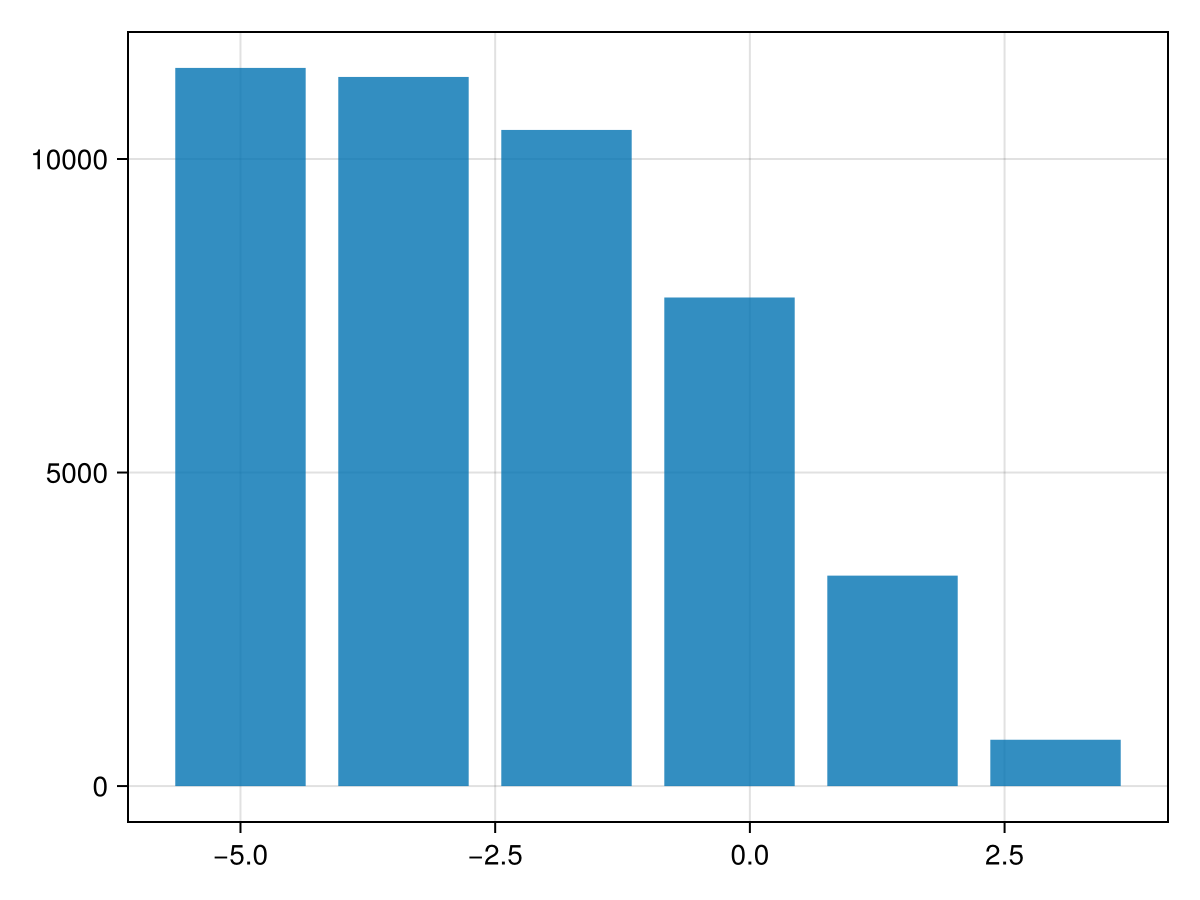

In [225]:
xx = freqtable(df, :DR)
# barplot(names(xx, 1), collect(xx))
faa = barplot(log10.(names(xx, 1)), collect(xx))

#### Two dim freqs

5×6 Named Matrix{Int64}
    DG ╲ DR │      1.0e-5  0.000398107    0.0158489     0.630957      25.1189       1000.0
────────────┼─────────────────────────────────────────────────────────────────────────────
0.000398107 │           1            1            0            0            0            0
0.0158489   │         111           82            8            2            0            0
0.630957    │         893          809          479           60            8            2
25.1189     │        3395         3366         2959         1509          256           55
1000.0      │        7052         7050         7017         6220         3092          682

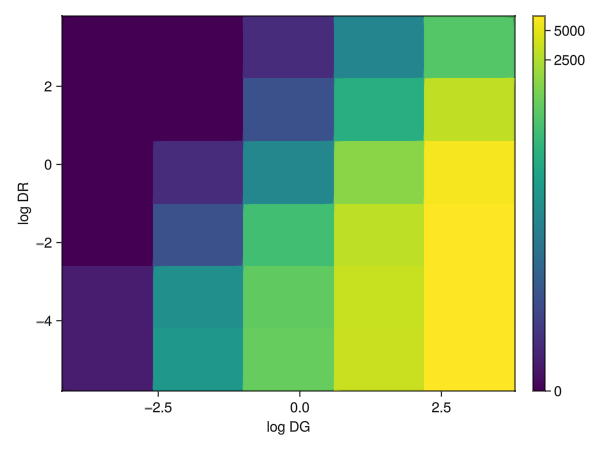

In [40]:
xx = freqtable(df, :DG, :DR)
display(xx)

xx.dimnames = Base.setindex(xx.dimnames, Symbol("log "*string(xx.dimnames[1])), 1)
setnames!(xx, log10.(names(xx, 1)), 1)
xx.dimnames = Base.setindex(xx.dimnames, Symbol("log "*string(xx.dimnames[2])), 2)
setnames!(xx, log10.(names(xx, 2)), 2)

fap = heatmap(names(xx, 1), names(xx, 2), xx; colorscale=Makie.pseudolog10)
Colorbar(fap.figure[1,2], fap.plot)

fap.axis.xlabel = string(dimnames(xx, 1))
fap.axis.ylabel = string(dimnames(xx, 2))

fap

#### Three dim freqs

In [93]:
yy = freqtable(df, :DR, :DG, :DR);

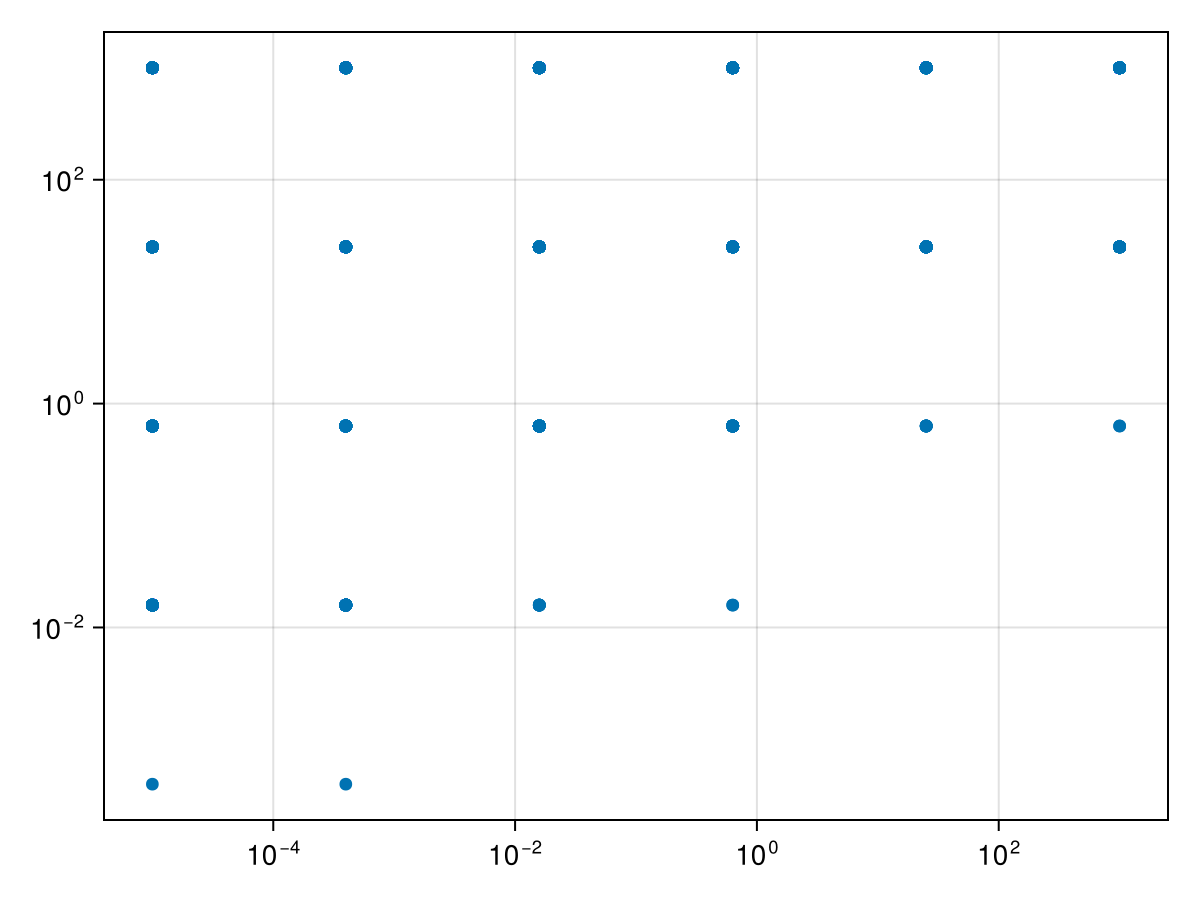

In [10]:
scatter(df.DR, df.DG; axis=(; yscale=log10, xscale=log10))

# Looking at a single system

In [97]:
mmpf = df_row_to_mmp(get_random_row(non1df));

In [131]:
# mmpf = MinimalModelParamsSpace(0.1, 0., 10., 0.01, 0.01, 1e-5, 0.01584893192461114, 0.00039810717055349735);
# mmpf = MinimalModelParamsSpace(fi_to_fparams(fi_to_run)...)
mmicrm_params = mmp_to_mmicrm(mmpf);
mmpf

MinimalModelParamsSpace{Float64}(0.23473272766542652, 0.1, 10.293319184075456, 0.12500000000000003, 0.03125000000000002, 0.04832930238571742, 100000.0, 1.0e-7)

In [132]:
xx = analyze_single_mmps(mmpf; include_extinct=true)
println((xx[1], xx[2]))
print("sss: ")
show(xx[3])
println()
print("kroots fe ss: ")
show(xx[4])
println()
print("nummodes fe ss fe segment: ")
show(xx[5])

(1, 2)
sss: [[33.71592030826229, 1.9739838618949035, 0.4051053824719953]]
kroots fe ss: [[0.25248736105283387, 0.2524873721186062]]
nummodes fe ss fe segment: [[1, 1, 0]]

## Numerics

In [134]:
all_sols = solve_nospace(mmpf)
p_sols = all_sols[nospace_sol_check_physical.(all_sols)]
display(p_sols)
nospace_sol_check_stable.(Ref(mmpf), p_sols)

2-element Vector{Vector{Float64}}:
 [33.71592030826229, 1.9739838618949035, 0.4051053824719953]
 [0.0, 10.293319184075456, 0.0]

2-element BitVector:
 1
 0

In [116]:
nssol = p_sols[1]

3-element Vector{Float64}:
 33.71592030826229
  1.9739838618949035
  0.4051053824719953

In [122]:
pp = make_K_polynomial(make_M1(mmicrm_params, nssol), get_Ds(mmpf))

4-element SVector{4, Float64} with indices SOneTo(4):
    -0.0004832930238571742
 -9925.01432544307
  1265.4367812480775
    -1.9655920319043023

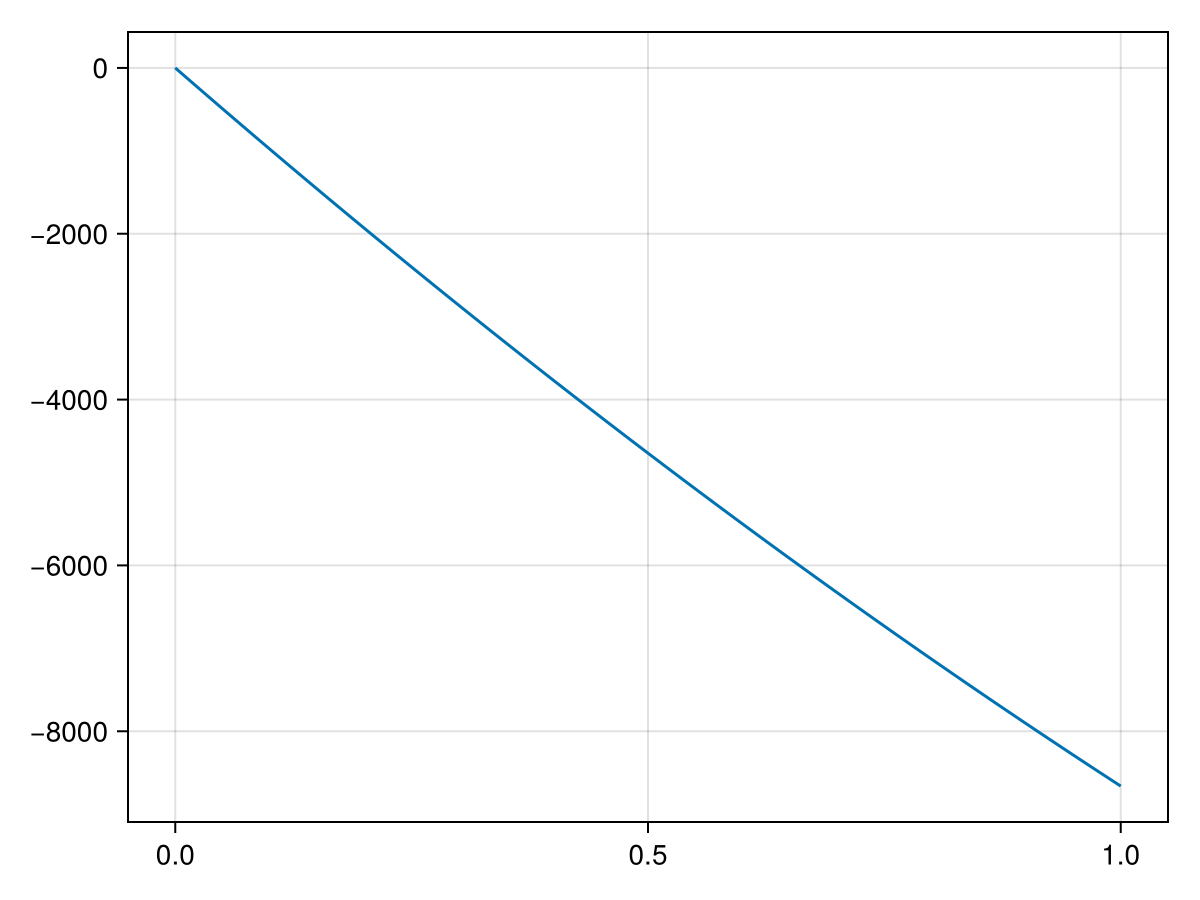

In [126]:
oo = map(x->sum((x .^ [0, 1, 2, 3]) .* pp), ks)
lines(ks, oo)

#### No space solver

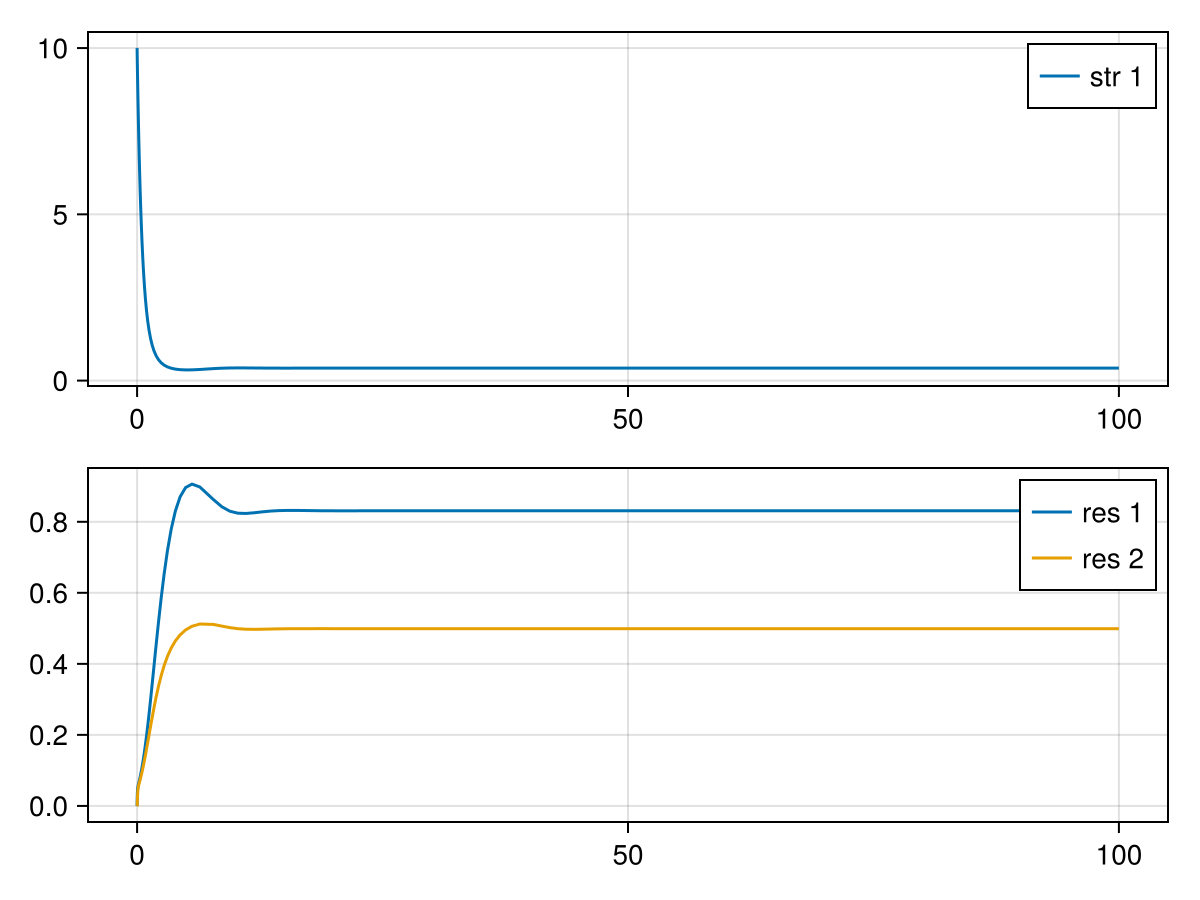

3-element Vector{Float64}:
 0.37499274594930904
 0.8310124854942964
 0.49900204474240867

In [185]:
# u0 = make_mmicrmu0_smart(mmicrm_params; u0=:onlyN)
u0 = [10., 0., 0.]
# u0 = nssol .* (1 .+ 10. .* (rand(3) .- 0.5))
nsp = ODEProblem(mmicrmfunc!, u0, (0, 100), mmicrm_params)
check_mmicrmparams(nsp.p)
s = solve(nsp)
display(plot_mmicrm_sol(s))
s.u[end]

#### Linstab

mrl = 0.004769905418865241


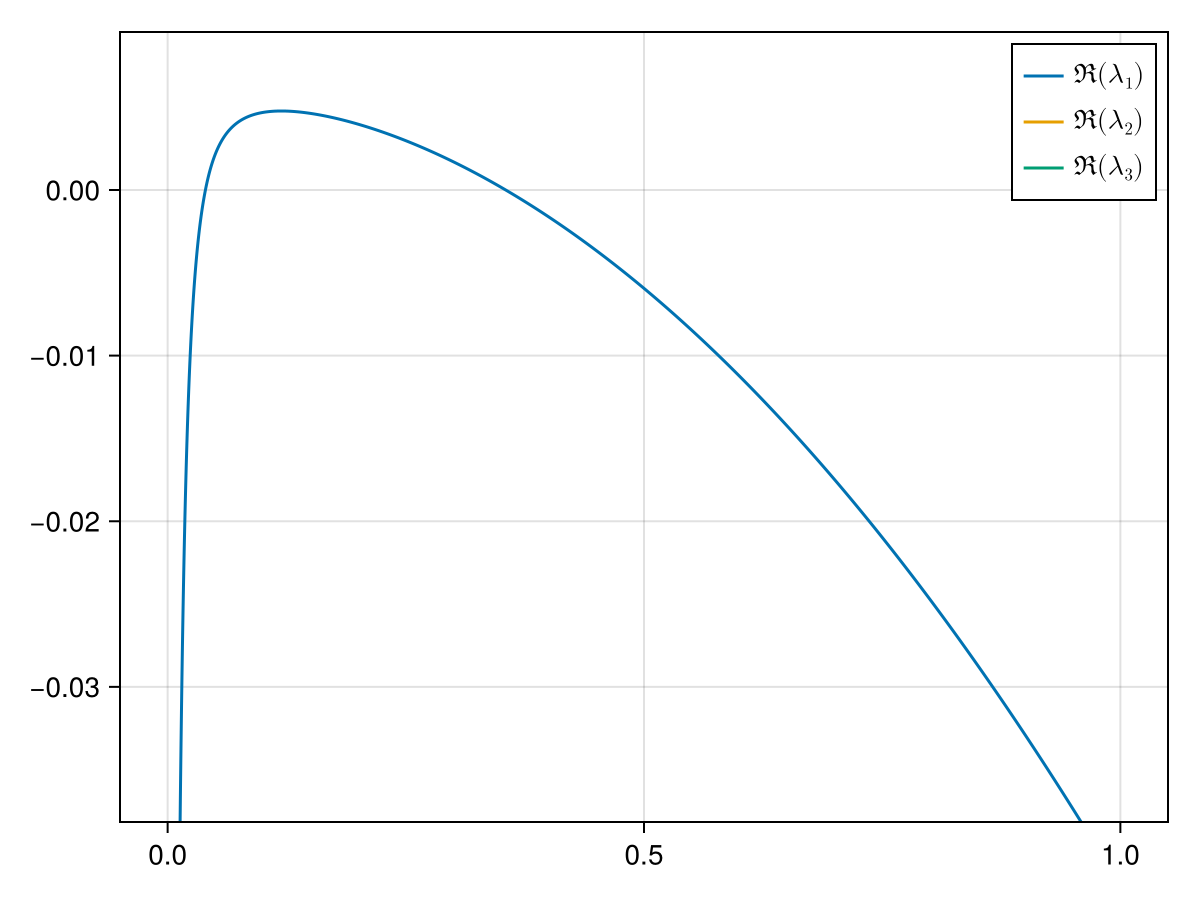

In [130]:
ks = LinRange(0., 1, 10000)
Ds = collect(get_Ds(mmpf))

lambdas = do_linstab_for_ks(ks, mmicrm_params, Ds, nssol);
mrl = maximum(real(lambdas))
@show mrl
faa = plot_linstab_lambdas(ks, lambdas)
ylims!(faa.axis, (-8*mrl, 2*mrl))
# xlims!(faa.axis, (0., 2.))
# display(GLMakie.Screen(), faa.figure)
faa

In [49]:
# Finds the k with the biggest maximum eigenvalue
kmax_i = argmax(maximum.(eachrow(real(lambdas))))
kmax = ks[kmax_i]
kmax_i, kmax
ff = linstab_make_full_func(mmicrm_params, nssol, Ds)
kmax_es = ff(kmax)
kmax_es.vectors[:,1] # the eigensystem is sorted by evalue so this is the one

3-element Vector{Float64}:
  0.9132060371498473
 -0.32073507156886566
  0.2513637753909385

### 1D PDE sim

In [97]:
ssize = (4000,)
su0 = expand_u0_to_size(ssize, nssol)
psu0 = perturb_u0_uniform(get_Ns(mmicrm_params)..., su0, 0.1, 0.1)
space = make_cartesianspace_smart(length(ssize); dx=0.00004, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing
sp = make_smmicrm_problem_safe(
    psu0, 1e6, mmicrm_params, get_Ds(mmpf), space, usenthreads;
)
size(sp.u0), sp.p.usenthreads, sp.p.space

((3, 4000), 18, CartesianSpace{1, Tuple{Periodic}, Float64}([4.0e-5]))

In [98]:
@time sps = solve(sp, QNDF(); maxiters=1000)
print_spatial_solution_stats(sps)

 16.792376 seconds (18.69 M allocations: 1.852 GiB, 42.19% gc time, 129.49% compilation time)
Success
nf is 419
solution has 119 saved states
max resid is 8.60798e-10


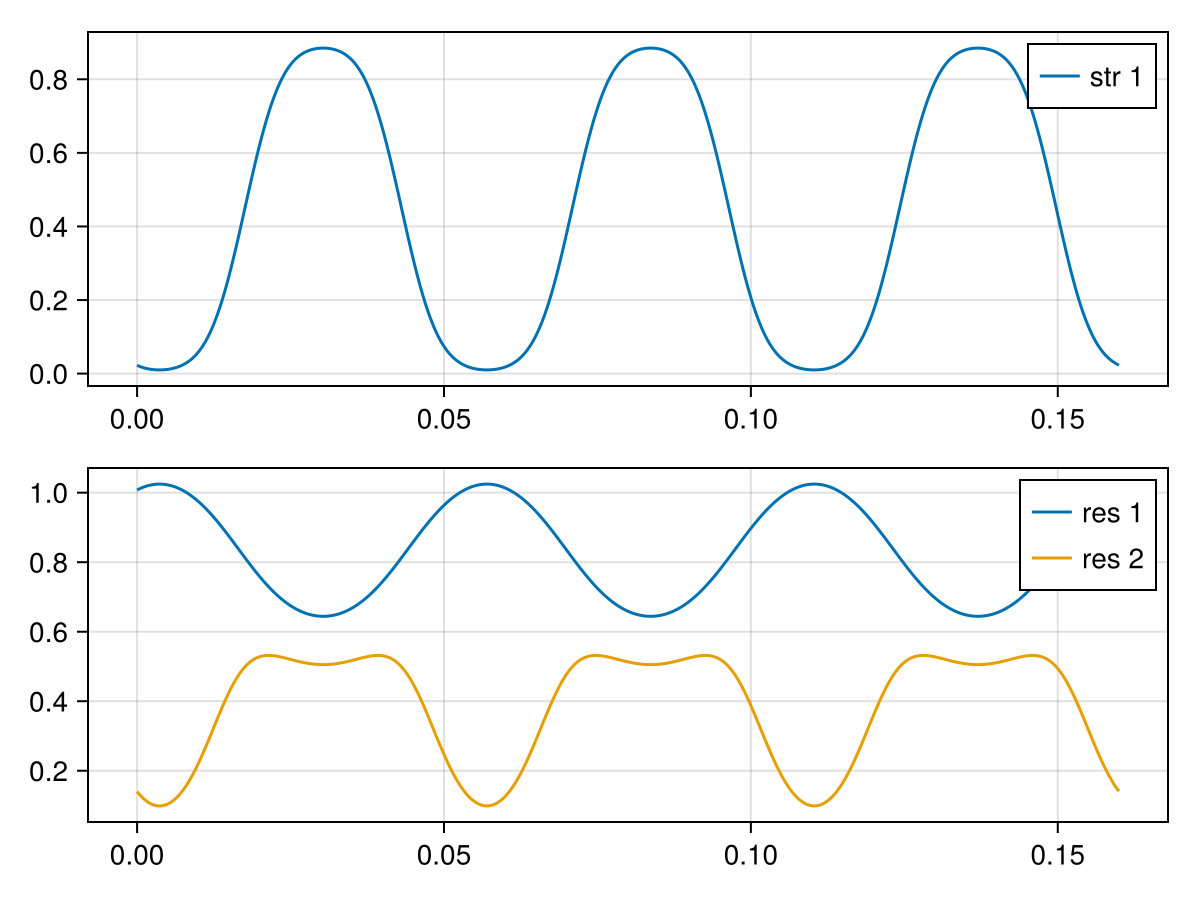

In [102]:
plot_1dsmmicrm_sol_snap(sps.prob.p, sps(sps.t[end]))

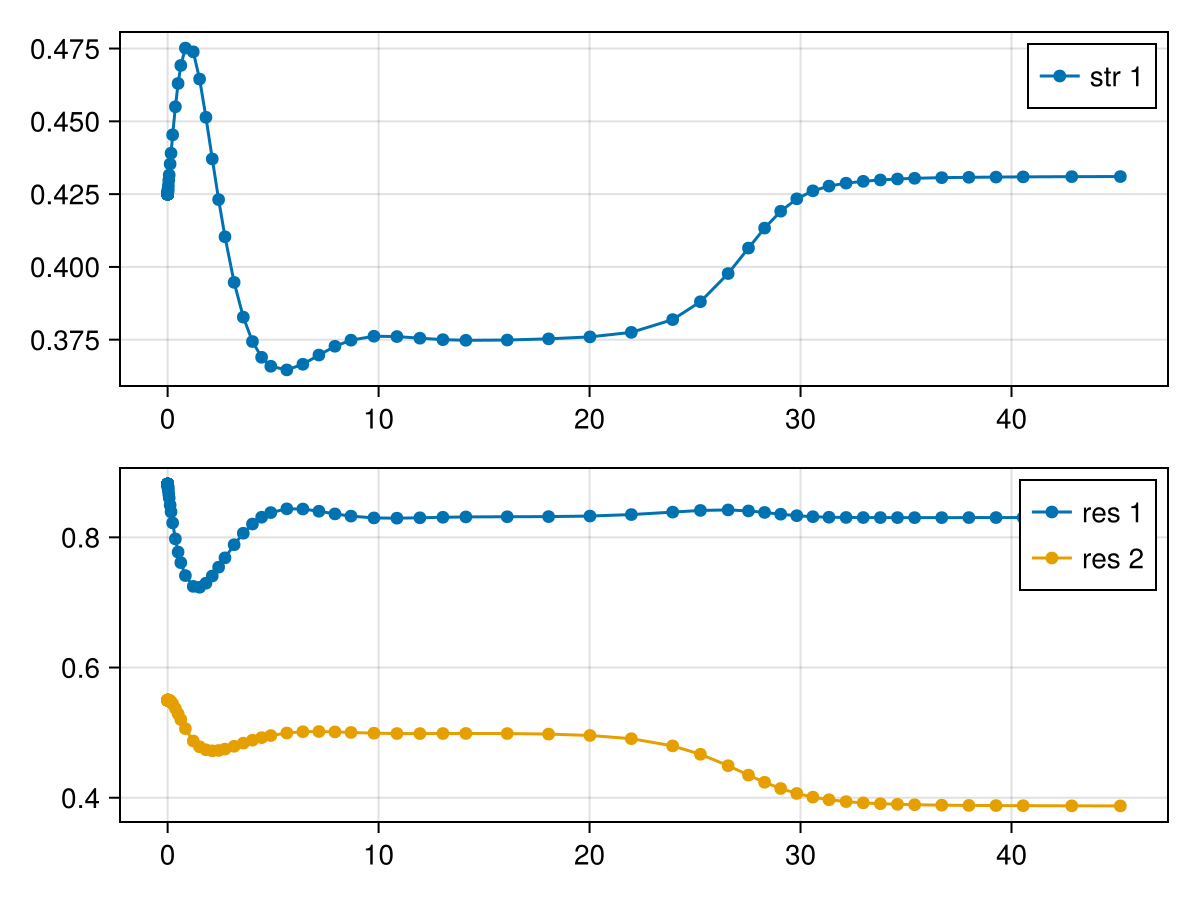

In [104]:
f = plot_smmicrm_sol_avgs(sps, 1:100)
# display(GLMakie.Screen(), f)